In [1]:
# 坐标计算和可视化
import numpy as np
from pylab import *
from matplotlib import pyplot as plt  
import time
import math

# 三个树莓派的坐标值
rb1x = 20
rb1y = 50
rb2x = 60
rb2y = 20
rb3x = 20
rb3y = 20


# 输入三个树莓派的距离，计算出WIFI信号坐标
def loc_calculate(r1,r2,r3):
    x12 = insec(rb1x,rb1y,r1,rb2x,rb2y,r2)
    x13 = insec(rb1x,rb1y,r1,rb3x,rb3y,r3)
    x23 = insec(rb2x,rb2y,r2,rb3x,rb3y,r3)
    x121 = x12[0]
    x122 = x12[1]
    x131 = x13[0]
    x132 = x13[1]
    x231 = x23[0]
    x232 = x23[1]
    p1 = choosepoint(x121,x122,x131,x132,x231,x232)
    p2 = choosepoint(x131,x132,x121,x122,x231,x232)
    p3 = choosepoint(x231,x232,x121,x122,x131,x132)
    p = (p1+p2+p3)/3
    print(p)
    return p


# 根据三个圆的六个交点选出合适的三个交点
def choosepoint(a1,a2,b1,b2,c1,c2):
    d11 = math.sqrt((abs(a1[0]-b1[0]))**2 + (abs(a1[1]-b1[1]))**2)
    d12 = math.sqrt((abs(a1[0]-b2[0]))**2 + (abs(a1[1]-b2[1]))**2)
    d13 = math.sqrt((abs(a1[0]-c1[0]))**2 + (abs(a1[1]-c1[1]))**2)
    d14 = math.sqrt((abs(a1[0]-c2[0]))**2 + (abs(a1[1]-c2[1]))**2)
    d1 = d11 + d12 + d13 + d14
    d21 = math.sqrt((abs(a2[0]-b1[0]))**2 + (abs(a2[1]-b1[1]))**2)
    d22 = math.sqrt((abs(a2[0]-b2[0]))**2 + (abs(a2[1]-b2[1]))**2)
    d23 = math.sqrt((abs(a2[0]-c1[0]))**2 + (abs(a2[1]-c1[1]))**2)
    d24 = math.sqrt((abs(a2[0]-c2[0]))**2 + (abs(a2[1]-c2[1]))**2)
    d2 = d21 + d22 + d23 + d24
    if d1 <= d2:
        return a1
    else:
        return a2


# 两圆求交点
def insec(x,y,r1,a,b,r2):
    R = r1
    S = r2
    d = math.sqrt((abs(a-x))**2 + (abs(b-y))**2)
    if d > (R+S) or d < (abs(R-S)):
        print ("Two circles have no intersection")
        #两圆相离
        if d > (R+S):
            x3 = (x*S+a*R)/(S+R)
            y3 = (y*R+b*S)/(S+R)
        #两圆包含
        elif S < R:
            x3 = a + (R+S-d)*(a-x)/(2*d)
            y3 = b + (R+S-d)*(b-y)/(2*d)
        elif S > R:
            x3 = x + (R+S-d)*(x-a)/(2*d)
            y3 = y + (R+S-d)*(y-b)/(2*d)
        else:
            print("ERROR in logic")
        
        c1=np.array([x3, y3])
        c2=np.array([x3, y3])
        return c1,c2
    else:
        A = (R**2 - S**2 + d**2) / (2 * d)
        h = math.sqrt(R**2 - A**2)
        x2 = x + A * (a-x)/d
        y2 = y + A * (b-y)/d
        x3 = round(x2 - h * (b - y) / d,2)
        y3 = round(y2 + h * (a - x) / d,2)
        x4 = round(x2 + h * (b - y) / d,2)
        y4 = round(y2 - h * (a - x) / d,2)
        print (x3, y3)
        print (x4, y4)
        c1=np.array([x3, y3])
        c2=np.array([x4, y4])
        return c1,c2
    
    
# 可视化模块
def loc_show(a,b,c = -1, d = -1, e = -1, f = -1):
    figure(figsize=(6,6), dpi=80)
    plt.title("WIFI Location Detection") 
    plt.xlabel("x axis") 
    plt.ylabel("y axis")
    plt.plot(rb1x,rb1y,"ob",markersize=10,label="raspberry1") 
    plt.plot(rb2x,rb2y,"og",markersize=10,label="raspberry2") 
    plt.plot(rb3x,rb3y,"or",markersize=10,label="raspberry3") 
    plt.plot(a,b,"*r",markersize=15,label="wifi1")
    if(c!=-1):
        plt.plot(c,d,"*g",markersize=15,label="wifi2")
    if(e!=-1):
        plt.plot(e,f,"*b",markersize=15,label="wifi3")
    xlim(0,100)
    ylim(0,100)
    plt.legend()
    plt.show()



In [2]:
### 主树莓派程序，收集全部测距结果并计算输出


import zmq
import sys
import time
import os
from random import randint
import smbus
import threading
from rpi_ws281x import Adafruit_NeoPixel, Color

num_agents = 3
# broker_ip = sys.argv[1]
# agent_id = int(sys.argv[2])
# 主节点ip地址
broker_ip = '192.168.137.233'
agent_id = 1
send_flag = False

# 设置全局变量保存移动终端的数据，并设为空
yzy1 = None
yzy2 = None
yzy3 = None
cxk1 = None
cxk2 = None
cxk3 = None


# port = 1
# bus = smbus.SMBus(port)

# 搜索附近的wifi
def scan_wifi():
    os.system('wpa_cli -i wlan0 scan')
    # 显示搜索wifi热点的结果
    str = os.popen('wpa_cli -i wlan0 scan_result')
    return str

# 获取移动终端的热点信息
def recv_wifi(threadName, delay):
    global cxk1, yzy1   #主
    
    print("success3:recv from phone")
    while True:
        r=scan_wifi()
        info = r.readlines()
        for line in info:
            line = line.strip('\r\n')
            mac = line[0:17]

            # 判断移动终端的mac地址
            if mac == '54:25:ea:4c:22:c0':
                print('recv_wifi %d: %s' % (agent_id, line))
                # 分离出mac rssi name
                pos = line.find('[')
                rssi = line[24:pos-1]
                line_length = len(line)
                pos2 = line.rfind(']')
                name = line[pos2+2:line_length]
                # print('mac: %s, rssi:%s, name:%s '% (mac, rssi, name))
                # 记入global info
                yzy1=rssi+'-'+name
            
            if mac == '74:60:fa:81:a8:d8':
                print('recv_wifi %d: %s' % (agent_id, line))
                # 分离出mac rssi name
                pos = line.find('[')
                rssi = line[24:pos-1]
                line_length = len(line)
                pos2 = line.rfind(']')
                name = line[pos2+2:line_length]
                # print('mac: %s, rssi:%s, name:%s '% (mac, rssi, name))
                # 记入global info
                cxk1=rssi+'-'+name

        time.sleep(delay)


        
# 扫描信道接收来自副树莓派的距离信息
def scanner(threadName, delay):
    global cxk2, yzy2
    global cxk3, yzy3
    
    print("success4:begin scanner for pi")
    context = zmq.Context()
    publisher = context.socket(zmq.PUB)
    publisher.connect("tcp://%s:5556" % broker_ip)

    subscriber = context.socket(zmq.SUB)
    subscriber.connect("tcp://%s:5555" % broker_ip)
    # 筛选出开头为'1'的树莓派信息
    subscriber.setsockopt_string(zmq.SUBSCRIBE, str(1))
    while True:
        print('s5')
        message = subscriber.recv()
        print('s6:recv from pi')
        print(message)
        # 分离数据
        num = message[0:2]  # 树莓派编号
#         print('num:',num)
        mac = message[4:21]
        pos = message.find(b'-')
        pos2 = message.find(b'[')
        rssi = message[pos+1:pos2-1]
        line_length = len(message)
        pos3 = message.rfind(b']')
        name = message[pos3+2:line_length]
        # 记入global info
        if num == b'12':
            if mac == b'54:25:ea:4c:22:c0':
                yzy2 = rssi + b'-' + name
            elif mac == b'74:60:fa:81:a8:d8':
                cxk2 = rssi + b'-' + name
        elif num == b'13':
            if mac == b'54:25:ea:4c:22:c0':
                yzy3 = rssi + b'-' + name
            elif mac == b'74:60:fa:81:a8:d8':
                cxk3 = rssi + b'-' + name
        else:
            print('not a sender')
    

        time.sleep(delay)
        
        
        
# 从rssi计算距离，3台树莓派参数不同
def get_distance_1(rssi):
    A = -35.5  # typical 45-49
    n = 4.6   # typical 3.25—4.5
    d = 10**((abs(rssi) - A) / (10 * n))
    return d

def get_distance_2(rssi):
    A = -35.5  # typical 45-49
    n = 4.6   # typical 3.25—4.5
    d = 10**((abs(rssi) - A) / (10 * n))
    return d

def get_distance_3(rssi):
    A = -35.5  # typical 45-49
    n = 4.6   # typical 3.25—4.5
    d = 10**((abs(rssi) - A) / (10 * n))
    return d
        
        
# 计算热点位置，输出可视化结果
def get_pos(threadName, delay):
    while True:
        # 移动端1
        # 判断是否集全三个树莓派信息，均不为空则开始计算坐标
        pos1 = [-1, -1]
        pos2 = [-1, -1]
        print('yyyyyyy:',yzy1,yzy2,yzy3)
        if yzy1 and yzy2 and yzy3:
            rssi_1 = float(yzy1[0:2])
            rssi_2 = float(yzy2[0:2])
            rssi_3 = float(yzy3[0:2])
            dis_1 = get_distance_1(rssi_1)
            dis_2 = get_distance_2(rssi_2)
            dis_3 = get_distance_3(rssi_3)
            print('dis:', dis_1, dis_2, dis_3)
            pos1 = loc_calculate(dis_1, dis_2, dis_3)
#             loc_show(pos1[0], pos1[1])
        else:
            print('yzy Not Found')
        
        # 移动端2
        print('ccccccc:',cxk1,cxk2,cxk3)
        if cxk1 and cxk2 and cxk3:
            rssi_1 = float(cxk1[0:2])
            rssi_2 = float(cxk2[0:2])
            rssi_3 = float(cxk3[0:2])
            dis_1 = get_distance_1(rssi_1)
            dis_2 = get_distance_2(rssi_2)
            dis_3 = get_distance_3(rssi_3)
            print('dis:', dis_1, dis_2, dis_3)
            pos2 = loc_calculate(dis_1, dis_2, dis_3)
#             loc_show(pos2[0], pos2[1])
        else:
            print('cxk Not Found')
        
        # 可视化
        loc_show(pos1[0], pos1[1], pos2[0], pos2[1])
        
        time.sleep(delay)
    
        

exitFlag = 0
global val
# 定义线程
# 继承父类threading.Thread
class myThread1 (threading.Thread):   
    def __init__(self, threadID, name, counter):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.counter = counter
    def run(self):
        # 接收wifi热点信息
        if self.threadID == 1:           
            recv_wifi(self.name, 0.5)
        # 获取其他树莓派的热点距离信息
        if self.threadID == 2:
            scanner(self.name, 0.5)
        # 计算位置，输出可视化结果
        elif self.threadID == 3:
            get_pos(self.name, 3)


def main():
    # 根据agent_id点亮不同位置的灯区分树莓派 1 2 3
    print('suceess0:the number of this pi is %d:',agent_id)
    strip = Adafruit_NeoPixel(32, 18, 800000, 10, False, 10)
    strip.begin()
    strip.setPixelColor(agent_id, Color(255, 0, 0))
    strip.show()
    

    print('suceess1:begin thread')
    # 创建新线程
    thread1 = myThread1(1, "Thread-1", 1)
    thread2 = myThread1(2, "Thread-2", 2)
    thread3 = myThread1(3, "Thread-3", 3)
 
    # 开启线程
    thread1.start()
    thread2.start()
    thread3.start()


suceess0:the number of this pi is %d: 1
suceess1:begin thread
success3:recv from phone
success4:begin scanner for pi
s5
yyyyyyy: None None None
yzy Not Found
ccccccc: None None None
cxk Not Found
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-34	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'


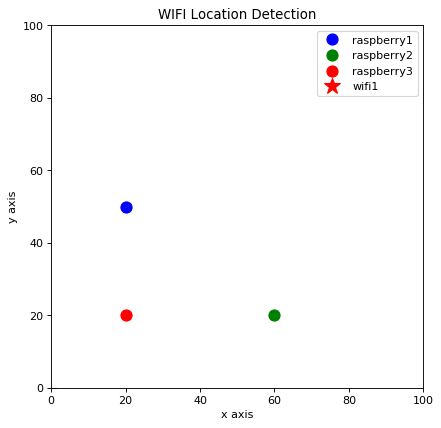

recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-22\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-43\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-32	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-28\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-32	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5

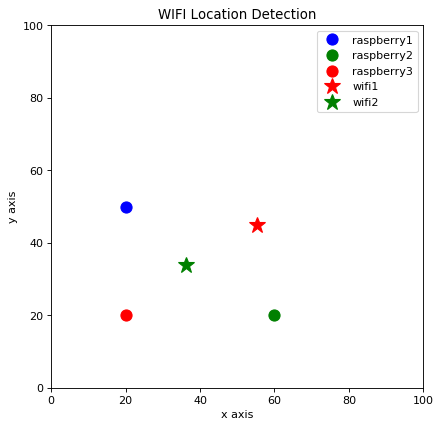

recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-28\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-21\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-43\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5

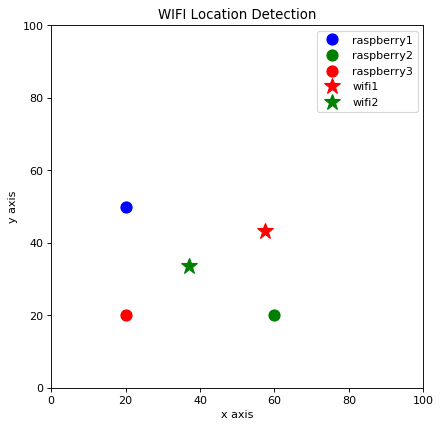

s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-27\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-25	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-28\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-25	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-22\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-25	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-40\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-27\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-25	[WPA2-PSK-CCMP][ESS]	HUA

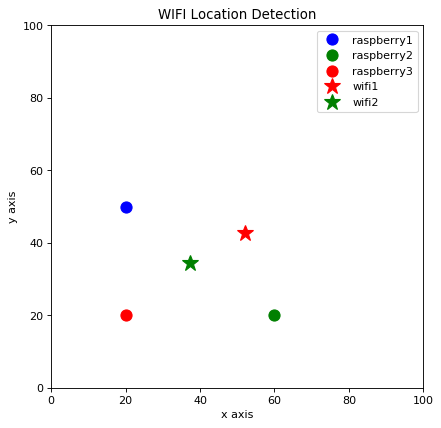

recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-31	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-29\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-31	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-21\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-37	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-42\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-37	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5

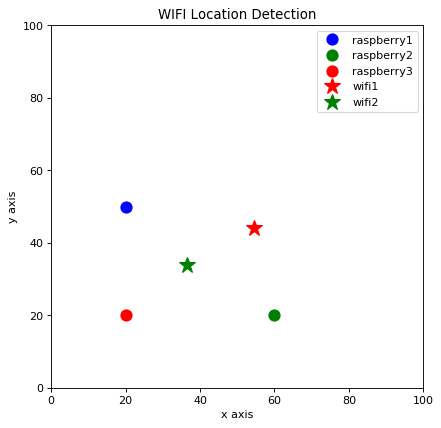

s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-21\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-25	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-32	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-50\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-25	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-32	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-30\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-21\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-24	[WPA2-PSK-CCMP][ESS]	HUA

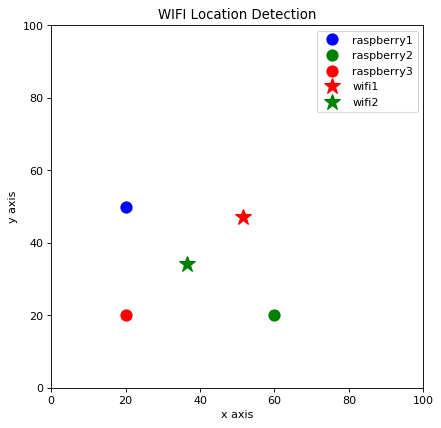

recv_wifi 1: 74:60:fa:81:a8:d8	2437	-25	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-23\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-25	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-50\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-22	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-37	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-22	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-37	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-30\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
s5

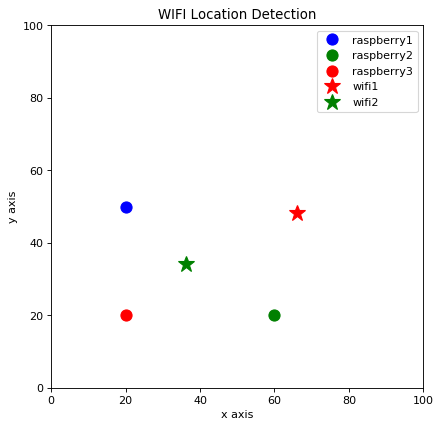

recv_wifi 1: 74:60:fa:81:a8:d8	2437	-29	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-38	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-23\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-29	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-38	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-19\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-34	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-42\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-34	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
re

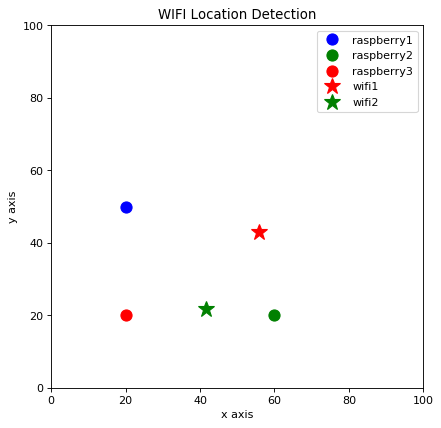

s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-34	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-36	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-29\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-38	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-22\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-38	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-45\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-38	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5

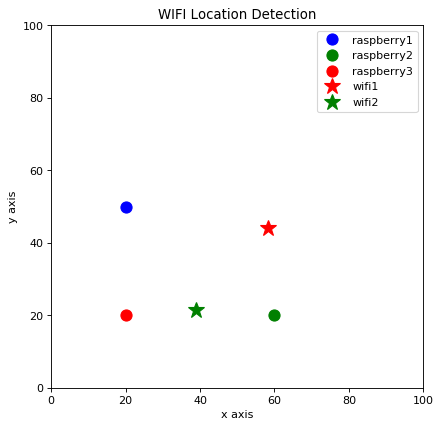

s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-45\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-38	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-34	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-27\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-38	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-34	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-27\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-41	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-34	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-22\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-41	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-34	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5

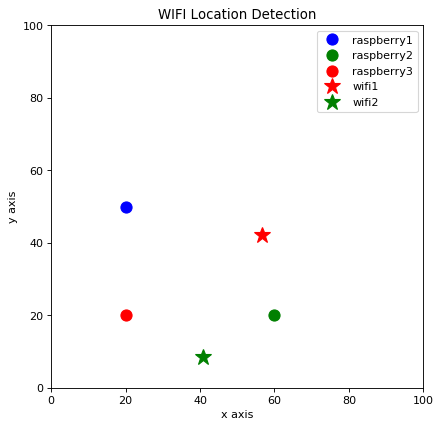

recv_wifi 1: 74:60:fa:81:a8:d8	2437	-39	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-22\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-39	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-42\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-38	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxks5
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro

s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-28\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-28\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-38	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5

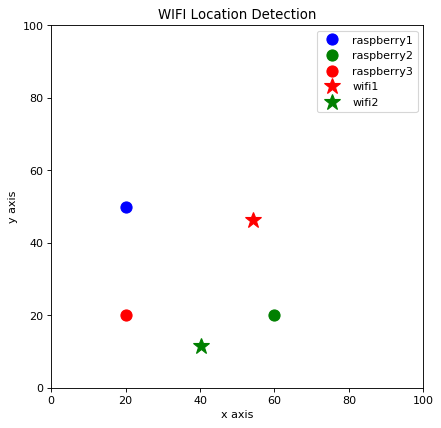

recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-28\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-39	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-22\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-30	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-41	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-44\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-30	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-41	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-29	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
re

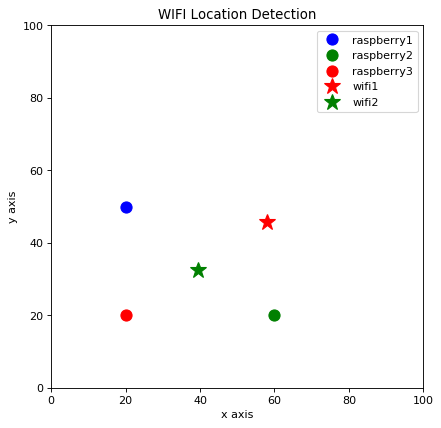

s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-27\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-29	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-43	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-27\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-29	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-43	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-24\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-40\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-28	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-42	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-27\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-28	[WPA2-PSK-CCMP][ESS]	HUA

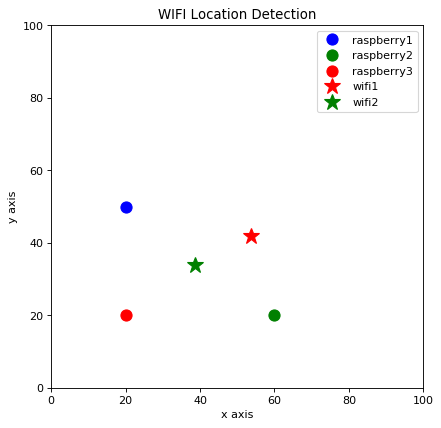

s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-42\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-27	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-36	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-27	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-36	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-29\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-27	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-22\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-27	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5

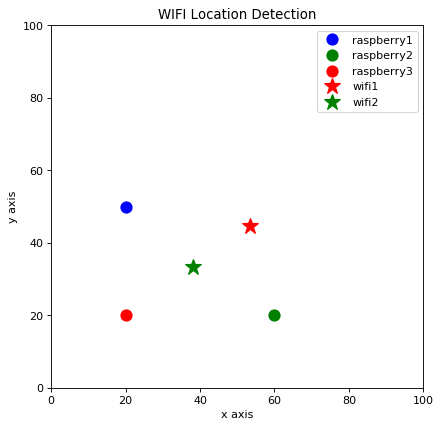

s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-22\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-28	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-42\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-28	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-26\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-27	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-30\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-27	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5

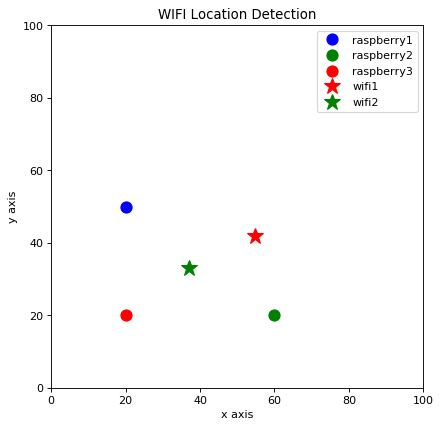

s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-29\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-28	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-22\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-28	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-35	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-38\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-28	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-24\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-28	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5

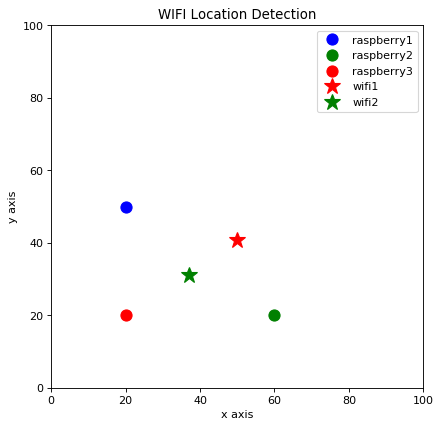

recv_wifi 1: 74:60:fa:81:a8:d8	2437	-29	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 74:60:fa:81:a8:d8\t2437\t-24\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-29	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-33	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'12: 74:60:fa:81:a8:d8\t2437\t-27\t[WPA2-PSK-CCMP][ESS]\tHUAWEI P30 cxk'
s5
s6:recv from pi
b'12: 54:25:ea:4c:22:c0\t2412\t-22\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-28	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-31	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5
s6:recv from pi
b'13: 54:25:ea:4c:22:c0\t2412\t-42\t[WPA2-PSK-CCMP][ESS]\tHUAWEI Mate 9 Pro'
recv_wifi 1: 74:60:fa:81:a8:d8	2437	-28	[WPA2-PSK-CCMP][ESS]	HUAWEI P30 cxk
recv_wifi 1: 54:25:ea:4c:22:c0	2412	-31	[WPA2-PSK-CCMP][ESS]	HUAWEI Mate 9 Pro
s5

In [3]:
main()